In [27]:
from os import listdir
from os.path import join
from datetime import date, time, datetime

import calendar
import gzip
import json

In [28]:
# Utils
def languages():
    return [
        "english"
    ]

In [29]:
# Global variables

# Leave empty if all domains should be processed
# Example for fetching wsj domain: ["wsj.com"]
_domain = ""
_folder = "release"

_filter = ['covid-19', 'covid', 'covid19', 'coronavirus']
_debug = False

# Number of most popular named entities displayed
_namedEntities = 10

In [30]:
# Standardization NLTK encapsulation

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tree import Tree
from nltk.stem.porter import *

_wordnetLemmatizer = WordNetLemmatizer()

def _sentence_tokenize_NLTK(text):
    return sent_tokenize(text)
    
def _word_tokenize_NLTK(text):
    return word_tokenize(text)

# {cars -> car}, {rocks -> rock}
def _lemmatize_NLTK(text):
    result = _wordnetLemmatizer.lemmatize(text)
    # To handle adjectives like: better -> good
    return _wordnetLemmatizer.lemmatize(result, pos = "a")

def _speech_tag_NLTK(wordList):
    return nltk.pos_tag(wordList)

def _named_entities_chunk_NLTK(taggedList):
    return nltk.ne_chunk(taggedList)

In [31]:
# Standardization default logic

# Gets all letters before the index value
def get_prefix(text, i):
    return text[:i]

# Gets all letters after the index value
def get_postfix(text, i):
    try:
        return text[i+1:]
    except:
        return ""

def get_postfix_including_current(text, i):
    try:
        return text[i:]
    except:
        return ""

def is_punctuation_for_sentence_tokenize(letter):
    punctuations = ".?!"
    if letter in punctuations:
        return True
    return False

def is_punctuation_for_word_tokenize(letter):
    punctuations = ".?'’:!,"
    if letter in punctuations:
        return True
    return False

def is_end_of_sentence(text, i):
    prefix = get_prefix(text, i)
    postfix = get_postfix(text, i)
    # If this is the last character
    if(postfix == ""):
        return True

    # If we are at space character
    if(text[i] == " "):
        if(prefix != ""):
            if(is_punctuation_for_sentence_tokenize(text[i-1])):
                return True
    return False

def string_contains_only(_str, char):
    for i in _str:
        if(i != char):
            return False
    return True

# Standardization default encapsulation
def _sentence_tokenize_DEFAULT(text, _list=[]):
    i = 0
    for l in text:
        if(is_end_of_sentence(text, i)):
            _list.append(get_prefix(text, i+1).strip())
            _sentence_tokenize_DEFAULT(get_postfix(text, i), _list)
            break
        i+=1
    return _list

# Only returns true for last letter in acronym
# E.g. 
# Letter: A   Prefix: U.S.   Postfix: .
# A is the last letter in U.S.A. therefore it's True
def is_last_in_acronym(letter, prefix, postfix):
    if(letter.isalpha() == False):
        return False

    if(postfix != ""):
        if(postfix[0] == "."):
            if(prefix != ""):
                if(prefix[len(prefix)-1] == "."):
                    return True
    return False

def is_end_of_word(text, i):
    prefix = get_prefix(text, i)
    postfix = get_postfix(text, i)

    # If last letter
    if(postfix == ""):
        return True

    # If punctuation and next letter is space
    if(is_punctuation_for_word_tokenize(text[i])):
        if(postfix[0] == " "):
            return True
        else:
            # Handle "...ab" to "... ab"
            if(prefix == "" or is_punctuation_for_word_tokenize(prefix[i-1])):
                if(postfix[0].isalpha() or postfix[0].isnumeric()):
                    return True
        return False

    # If we have a letter or number
    if(text[i].isalpha() or text[i].isnumeric()):
        if(postfix[0] == " "):
            return True
        # If next letter is a punctuation
        elif(is_punctuation_for_word_tokenize(postfix[0])):
            innerPostfix = get_postfix(text, i+1)
            # Spot 's ending of words
            if(postfix[0] == "'" or postfix[0] == "’"):
                if(innerPostfix != ""):
                    if(innerPostfix[0] == "s"):
                        return True
            
            # Handles "Acronyms"
            if(postfix[0] == "."):
                # Check if this belongs to a acronym, then return False
                if(is_last_in_acronym(text[i], prefix, postfix)):
                    return False

            # If second next letter is space (to cover someURL.com)
            if(innerPostfix != ""):
                if(is_punctuation_for_word_tokenize(innerPostfix[0])):
                    return True
                if(innerPostfix[0] != " "):
                    return False
                return True
            return True
    return False

def word_tokenize_DEFAULT(text, _list=[]):
    i=0
    word = ""
    for l in text:
        word+=l
        if(is_end_of_word(text, i)):
            if(word != ""):
                _list.append(word.strip())
            word_tokenize_DEFAULT(get_postfix(text, i), _list)
            break
        i+=1
    return _list

def _word_tokenize_DEFAULT(text):
    return word_tokenize_DEFAULT(text, [])

In [32]:
# Standardization
_useDefault = True

def _sentence_tokenize(text):
    if(_useDefault):
        return _sentence_tokenize_DEFAULT(text, [])
    else:
        return _sentence_tokenize_NLTK(text)

def _word_tokenize(text):
    if(_useDefault):
        return _word_tokenize_DEFAULT(text)
    else:
        return _word_tokenize_NLTK(text)
    
def _lemmatize(text):
    return _lemmatize_NLTK(text)

def _stopwords():
    stopWordsList = set()
    for l in languages():
        stopWordsList = set.union(stopWordsList, set(stopwords.words(l)))
    return stopWordsList

def _speech_tag(wordList):
    return _speech_tag_NLTK(wordList)

def _named_entities_chunk(taggedList):
    return _named_entities_chunk_NLTK(taggedList)

In [33]:
# Bulk standardization

# Remove trailing text like "- ABC News" or "| Al Jazeera"
def split_and_remove_last_part(text, split):
    spl = text.split(split)

    # At least one "split char" is included in text
    if(len(spl) > 1):
        spl.pop()
        
    return ' '.join(map(str, spl))

def clean_text(text):
    text = split_and_remove_last_part(text, " - ")
    text = split_and_remove_last_part(text, " | ")
    return text

def sentence_tokenize(text):
    return _sentence_tokenize(text)

# Expects a list from sentence tokenizing
def word_list_tokenize(sentenceList):
    tokenized = []
    for bulk in sentenceList:
        for w in _word_tokenize(bulk):
            tokenized.append(w)
    return tokenized

def lemmatization(stemmedList):
    lemmaList = []
    for w in stemmedList:
        lemmaList.append(_lemmatize(w))
    return lemmaList

def remove_stopwords(wordList):
    returnList = []
    for w in wordList:
        if w not in _stopwords():  
            returnList.append(w)
    return returnList

def remove_punctuations(wordList):
    punctuations = ".?:!,;‘-’|"
    returnList = []
    for w in wordList:
        if w not in punctuations:
            returnList.append(w)
    return returnList

def list_to_lower(_list):
    returnList = []
    for w in _list:
        returnList.append(w.lower())
    return returnList

# Clean additional information from the article
def clean_article_information(text):
    for t in text_to_remove:
        if(text.find(t) > -1):
            text = text.replace(t,'')
    return text

def standardize(text):
    sentTokenized = sentence_tokenize(text)
    wordTokenized = word_list_tokenize(sentTokenized)
    lemma = lemmatization(wordTokenized)
    noStopwords = remove_stopwords(lemma)
    noPunctuations = remove_punctuations(noStopwords)
    return noPunctuations

# Standardize title and description
# First by cleaning additional information from the text
def standardize_and_combine(text1, text2):
    text = clean_text(text1)
    text += " "
    text += clean_text(text2)
    return standardize(text)

In [34]:
# Fetch data and standardize

# Get all domains if no domain is specified
def get_domains():
    if(_domain == ""):
        domains = []
        for name in listdir(_folder+"/."):
            domains.append(name)
        return domains
    else:
        return _domain

def convert_to_datetime(_date):
    if(len(_date) <= 3 or len(_date) == 5 or len(_date) == 7 or len(_date) > 8):
        raise Exception(f"Input date cannot include {len(_date)} digits - it must contain 4,6 or 8")
    if(len(_date) == 4):
        return date(year=int(_date[0:4]), month=1, day=1)
    if(len(_date) == 6):
        return date(year=int(_date[0:4]), month=int(_date[4:6]), day=1)
    if(len(_date) == 8):
        return date(year=int(_date[0:4]), month=int(_date[4:6]), day=int(_date[6:8]))

def compare_date_to_inputdate(_date, dateFrom, dateTo):
    if(dateFrom == "" and dateTo == ""):
        return True

    criteria = convert_to_datetime(_date)
    _dateFrom = convert_to_datetime("19000101")
    _dateTo = date.today()

    if(dateFrom != ""):
        _dateFrom = convert_to_datetime(dateFrom) 
    if(dateTo != ""):
        _dateTo = convert_to_datetime(dateTo)     
        
    if(_dateFrom <= criteria and criteria <= _dateTo):
        return True

    return False

""" Creates an array with all necessary information for eah article

Parameters
----------------
domains: list
    Example: ['france24.com', 'bbc.com']

Returns
----------------
list
    List of articles content with
    {id, domain, title + description (standardized), date}

"""
def get_articles(domains, dateFrom="", dateTo=""):
    if(dateFrom == ""):
        returnDateFrom = convert_to_datetime("19000101")
    else:
        returnDateFrom = convert_to_datetime(dateFrom)

    if(dateTo == ""):
        returnDateTo = date.today()
    else:
        returnDateTo = convert_to_datetime(dateTo)

    articles = []
    article = {}
    alreadyProcessed = []
    getAll = False
    if(dateFrom == "" and dateTo == ""):
        getAll = True

    for domain in domains:
        for f in listdir(join(_folder+"/"+domain, "per_day")):
            # Takes first 4 numbers from filename (e.g. filename: 20190104.gz)
            if(getAll or compare_date_to_inputdate(f[0:8], dateFrom, dateTo)):
                try:
                    d = json.load(gzip.open(join(_folder+"/"+domain, "per_day", f)))
                except:
                    continue
                for i in d:
                    # Prevent articles to be added more than once
                    if i not in alreadyProcessed:
                        alreadyProcessed.append(i)
                        articles.append({
                            "id": i,
                            "domain": domain,
                            "standardized": standardize_and_combine(d[i]["title"], d[i]["description"]),
                            "date": f[0:8]
                        })
                    else:
                        continue

    if(_debug):
        print("Articles fetched: ", len(articles))

    return articles, returnDateFrom, returnDateTo

def get_articles_by_month(domains, year, month):
    start, dayTo = calendar.monthrange(int(year), int(month))

    if(dayTo < 10):
        dayTo = "0"+str(dayTo)
    else:
        dayTo = str(dayTo)

    # Adding in front of single digit
    if(len(month) == 1):
        month = "0"+month

    dateFrom = year+month+"01"
    dateTo = year+month+dayTo

    return get_articles(domains, dateFrom, dateTo)

In [35]:
# Entity extraction
from itertools import islice

def entity_extraction(wordList):
    extracted = []
    
    # Tagging each word
    tagged = _speech_tag(wordList)
    chunk = _named_entities_chunk(tagged)
    for c in chunk:
        if type(c) == Tree:
            newItems = " ".join([token for token, pos in c.leaves()])
            if newItems not in extracted:
                extracted.append(newItems)
    return extracted

def count_elements(elements):
    _dict = {}
    if(len(elements) > 0):
        for words in elements:
            for w in words:
                try:
                    _dict[w] += 1
                except:
                    _dict[w] = 1    
    return _dict

def sort_dictionary_desc(_dict):
    return sorted(_dict.items(), key=lambda x: x[1], reverse=True)   

def filter_named_properties(elements):
    filtered = []
    _sorted = sort_dictionary_desc(elements)
    i = 0
    for w in _sorted:
        filtered.append(w)
        i += 1
        if(i >= _namedEntities):
            return filtered

    return filtered
    
def get_named_properties(positive):
    entities = []
    for article in positive:
        entities.append(entity_extraction(article["standardized"]))
    return count_elements(entities)

# The entry point for the named property extraction
def get_most_popular_named_properties(positive):
    namedProperties = get_named_properties(positive)
    return filter_named_properties(namedProperties)

In [36]:
# Display result

# importing the required module
import matplotlib.pyplot as plt

def display_graph(title, x_labels, y_labels):
    left = list(range(1, len(x_labels)+1))

    # plotting a bar chart
    plt.bar(left, y_labels, tick_label = x_labels,
            width = 0.8, color = ['red'])

    plt.rcParams["figure.figsize"] = (15,8)

    # plot title
    plt.title(title)

    # function to show the plot
    plt.show()

def create_plot_data_for_named_entities(entities):
    x_axis = []
    values = []
    for e in entities:
        x_axis.append(e[0])
        values.append(e[1])
    return x_axis, values

def display_results(accuracy, positive, negative, entities, domains, dateFrom, dateTo):
    displayAccuracy = "{:.2f}".format(accuracy * 100)
    displayPositive = "{:.2f}".format(float(positive)/(float(negative)+float(positive)) * 100)

    x_axis, y_axis = create_plot_data_for_named_entities(entities)

    print("========")
    print(f"Finished processing articles:")
    print(f"Positive: {positive}")
    print(f"Negative: {negative}")    
    print(f"DateFrom: {dateFrom}")
    print(f"DateTo: {dateTo}")
    print(f"Domains: {domains}")
    print(f"Accuracy: {displayAccuracy} %")
    print(f"Portion of positive: {displayPositive} % ")
    display_graph(f"{_namedEntities} most popular named entities from {dateFrom} to {dateTo}", x_axis, y_axis)
    print("========")

In [37]:
# Analyze

def add_to_predictiveValues(predictiveValues, _type):
    try:
        predictiveValues[_type] += 1
    except:
        predictiveValues[_type] = 1

def find_predictive_parameter(testClass, articleProbability):
    pWeight = articleProbability["positive"]
    nWeight = articleProbability["negative"]

    if(pWeight >= nWeight):
        if(testClass == "positive"):
            return "TP"
        else:
            return "FP"

    if(pWeight < nWeight):
        if(testClass == "positive"):
            return "FN"
        if(testClass == "negative"):
            return "TN"

def calculate_positive_vs_negative(articlesProbability):
    countPositive = 0
    countNegative = 0
    for article in articlesProbability:
        if(article['positive'] >= article['negative']):
            countPositive += 1
        else:
            countNegative += 1
    
    return countPositive, countNegative

def calculate_probability_by_article(article, trainingDataPropability, pProbability):
    articleProbability = {}
    for _trainingClass in trainingDataPropability:
        p = 1
        for word in article["standardized"]:
            try:
                p *= trainingDataPropability[_trainingClass][word]
            except:
                p *= 0.0001
        p *= pProbability [_trainingClass]
        articleProbability[_trainingClass] = p

    return articleProbability

def calculate_accuracy(TP, FP, FN, TN):
    numerator = TP + TN
    denominator = TP + TN + FP + FN
    return float(numerator) / float(denominator)

'''
testingData:{'positive': [  'id': '..', 'domain': '..', 'title': '..', 'title_standardized': '..',
                            'description': '...', 'description_standardized': '...']}
trainingDataPropability: {'positive': {'word': likelihood}, {'word2', likelihood}...,
                         'negative': {'word': likelihood}, {'word2', likelihood}...}
pPropability: {'positive': float_value, 'negative': float_value}
'''
def analize(testingData, trainingDataPropability, pPropability):
    predictiveValues = {"TP": 0, "FP": 0, "TN": 0, "FN": 0}
    articlesProbability = []

    for _class in testingData:
        for article in testingData[_class]:
            articleProbability = calculate_probability_by_article(article,
                                                                  trainingDataPropability,
                                                                  pPropability)

            predictiveParameter = find_predictive_parameter(_class, articleProbability)
            add_to_predictiveValues(predictiveValues, predictiveParameter)
            
            articlesProbability.append(articleProbability)

    positive, negative = calculate_positive_vs_negative(articlesProbability)
    accuracy = calculate_accuracy(predictiveValues["TP"],
                       predictiveValues["FP"],
                       predictiveValues["FN"],
                       predictiveValues["TN"])

    return accuracy, positive, negative

In [38]:
# Classifier
from sklearn.model_selection import train_test_split

def array_similarity(arr1, arr2):
    for a1 in arr1:
        for a2 in arr2:
            if(a1.lower() == a2.lower()):
                return True
    return False

def create_testing_and_training_data(articles):
    train, test = train_test_split(articles, test_size=0.2)
    
    return train, test

# Positive (articles that include '_filter' in title or description) will have index = 0
# Negative will have index = 1
def split_to_positive_and_negative(articles):
    positiveResults = []
    negativeResults = []
    processedIndexes = []

    for a in articles:
        if(array_similarity(a["standardized"], _filter) == True):
            positiveResults.append(a)
        else:
            negativeResults.append(a)

    return positiveResults, negativeResults


""" Convert to object for classification

Parameters
----------------
classified: list
    Example: {  'id': 'fb5e74aaa23103c9e97af27fee1a6be3'
                'domain': 'aljazeera.com'
                'title': ...
                'description': ...
                'title_standardized': ['pfizer', 'covid-19'..]
                'description_standardized': ['report', 'news'..]
             }

Returns
----------------
classified: object
    Example: {  "testing":  {"positive": [{article1},{article2}]},
                            {"negative": [{article1},{article2}}},
                "training": {"positive": [{article1},{article2}]},
                            {"negative": [{article1},{article2}]}
             }
"""
def convert_to_classification_object(articles):
    testAndTrain = create_testing_and_training_data(articles)

    if(_debug):
        print("All test:", len(testAndTrain[0]))
        print("All training: ", len(testAndTrain[1]))
        print("==")

    test = split_to_positive_and_negative(testAndTrain[0])
    train = split_to_positive_and_negative(testAndTrain[1])

    if(_debug):
        print("Test, positive: ", len(test[0]))
        print("Test, negative: ",len(test[1]))
        print("Train, positive: ", len(train[0]))
        print("Train, negative: ", len(train[1]))

    testing = {"positive":{}, "negative":{}}
    testing["positive"] = test[0]
    testing["negative"] = test[1]

    training = {"positive":{}, "negative":{}}
    training["positive"] = train[0]
    training["negative"] = train[1]

    classified = {"testing": {}, "training": {}}
    classified["testing"] = testing
    classified["training"] = training

    return classified

def count_total_frequencies(frequencies):
    count = 0
    for _class in frequencies:
        for w in frequencies[_class]:
            count += frequencies[_class][w]
    return count

# Input: Frequency object (described below)
# Output: {'positive': {'word':'likelihood', 'word2':'likelihood'}, 'negative': {...} }
def calculate_probability(frequencies):
    p_w = {"positive": {}, "negative": {}}
    for _class in frequencies:
        for w in frequencies[_class]:
            p_w[_class][w] = float(frequencies[_class][w]) / float(len(frequencies[_class]))
    return p_w

def count_frequencies(data, _class, freq):
    for word in data:
        try:
            freq[_class][word] += 1
        except:
            freq[_class][word] = 1
    return freq

""" Calculate frequencies from the classification

Parameters
----------------
Returns
----------------
frequencies: object
    Example: {  "positive": {"word", frequency},{"word", frequency}...,
                "negative": {"word", frequency},{"word", frequency}...,
             }
"""
def word_counter(trainingData):
    frequencies = {"positive": {}, "negative": {}}
    for _class in trainingData:
        for article in trainingData[_class]:
            count_frequencies(article["standardized"], _class, frequencies)
    return frequencies

# Gets the prior probability of P(type1)
def calculate_prior_propabilities(frequencies, type1, type2):
    return float(len(frequencies[type1])) / float(len(frequencies[type1]) + len(frequencies[type2]))

# Input: Standardized article object
def classify_and_analyze(articles):
    classified = convert_to_classification_object(articles)
    frequencies = word_counter(classified["training"])

    # Prior propabilities for positive and negative
    pPropability = {'positive': 0.0, 'negative': 0.0}
    pPropability['positive'] = calculate_prior_propabilities(frequencies, "positive", "negative")
    pPropability['negative'] = calculate_prior_propabilities(frequencies, "negative", "positive")
    
    # Analize
    accuracy, positive, negative = analize(classified["testing"],
                                              calculate_probability(frequencies),
                                              pPropability)
    allPositive = [*classified["training"]["positive"], *classified["testing"]["positive"]]

    namedProperties = get_most_popular_named_properties(allPositive)
    
    return accuracy, positive, negative, namedProperties

Finished processing articles:
Positive: 5517
Negative: 185474
DateFrom: 2020-01-01
DateTo: 2020-01-31
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.c

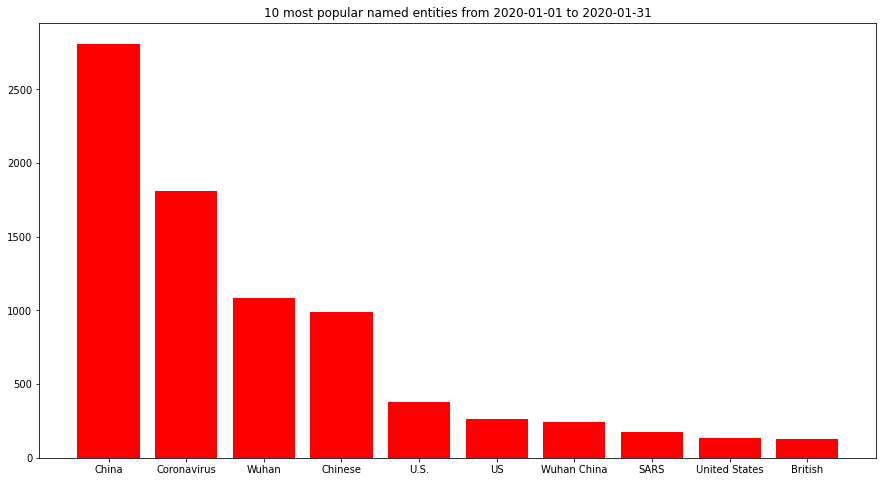

Finished processing articles:
Positive: 19490
Negative: 164756
DateFrom: 2020-02-01
DateTo: 2020-02-29
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.

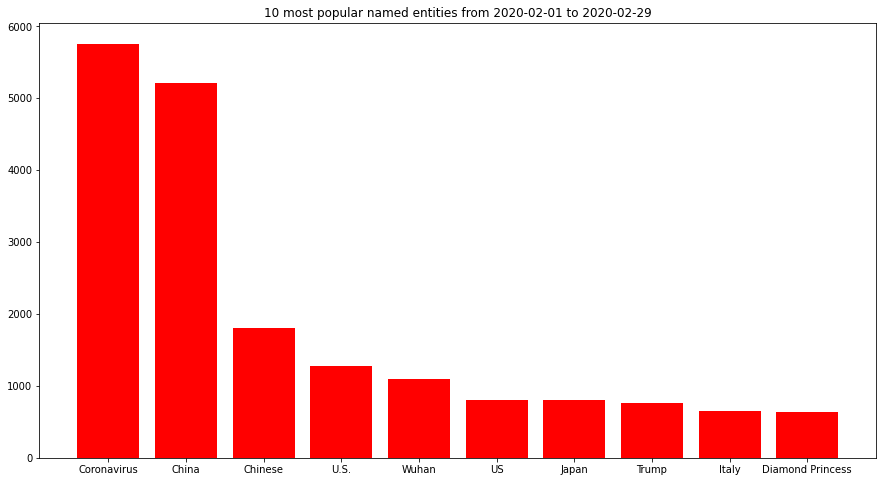

Finished processing articles:
Positive: 132157
Negative: 72225
DateFrom: 2020-03-01
DateTo: 2020-03-31
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.

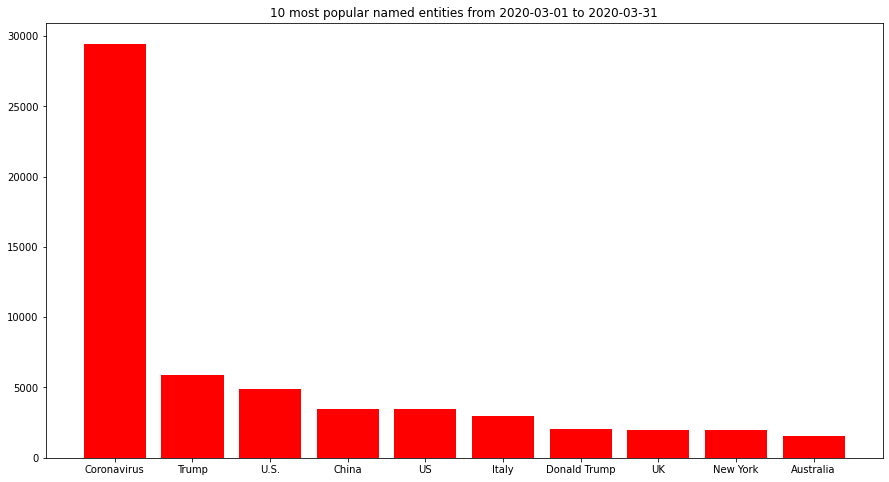

Finished processing articles:
Positive: 133457
Negative: 61320
DateFrom: 2020-04-01
DateTo: 2020-04-30
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.

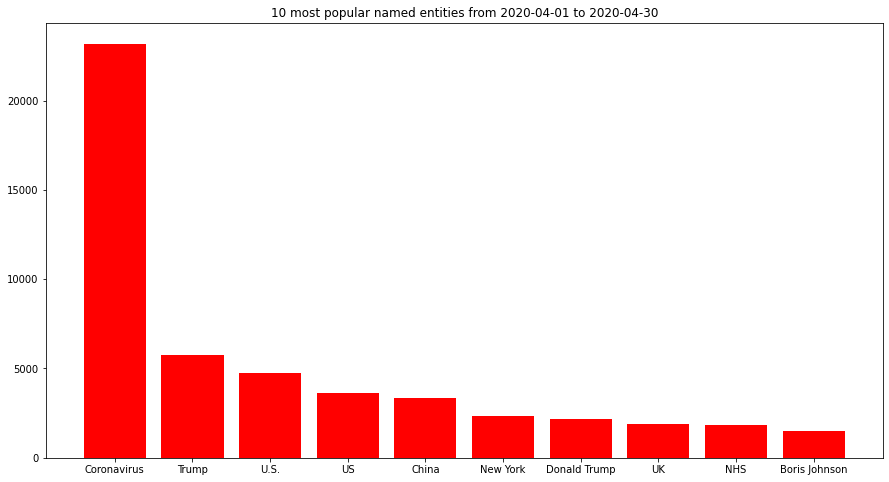

Finished processing articles:
Positive: 82867
Negative: 112645
DateFrom: 2020-05-01
DateTo: 2020-05-31
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.

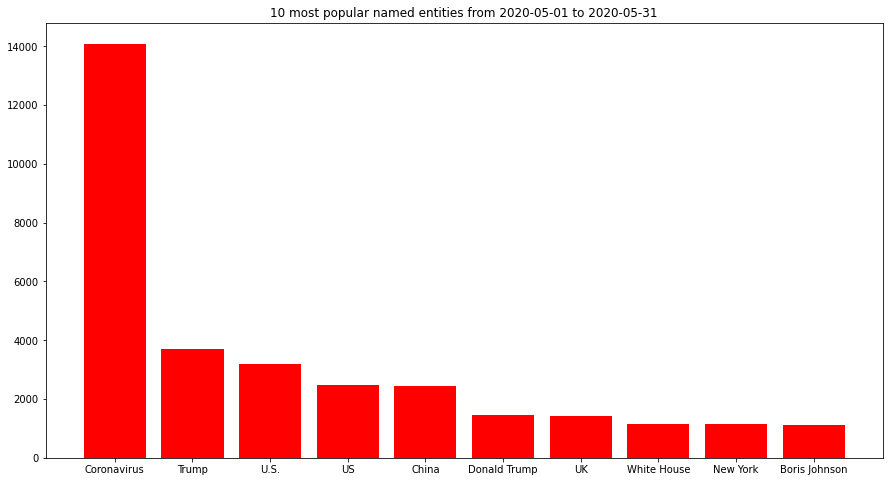

Finished processing articles:
Positive: 40278
Negative: 156586
DateFrom: 2020-06-01
DateTo: 2020-06-30
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.

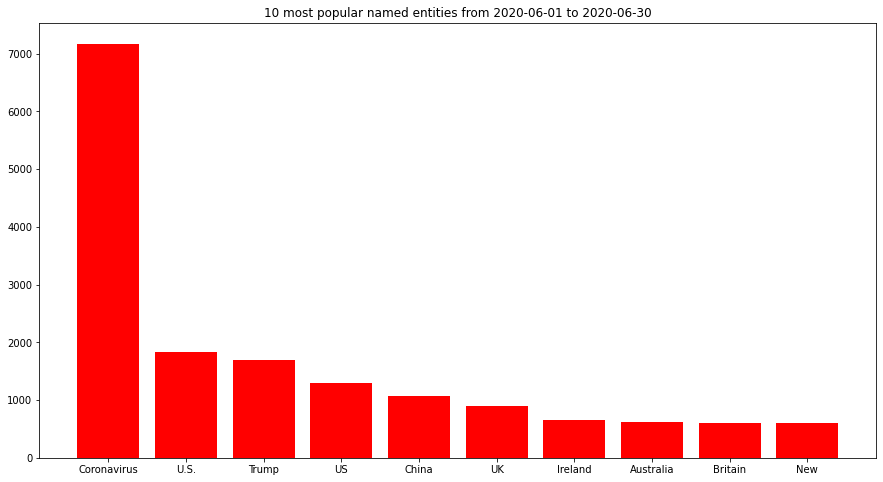

Finished processing articles:
Positive: 44929
Negative: 151213
DateFrom: 2020-07-01
DateTo: 2020-07-31
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.

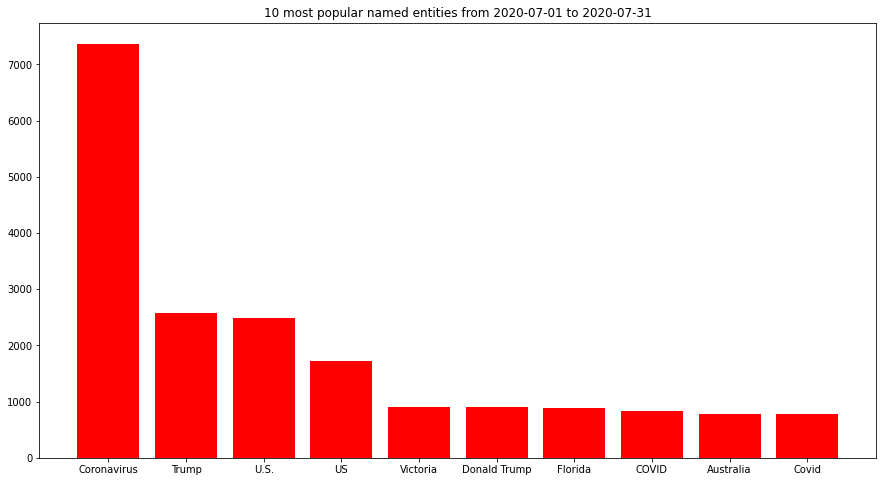

Finished processing articles:
Positive: 32600
Negative: 148989
DateFrom: 2020-08-01
DateTo: 2020-08-31
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.

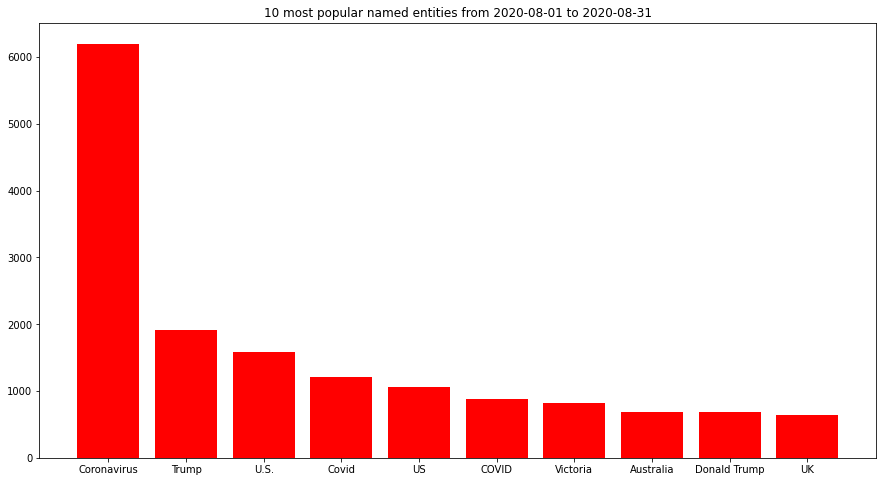

Finished processing articles:
Positive: 27700
Negative: 144673
DateFrom: 2020-09-01
DateTo: 2020-09-30
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.

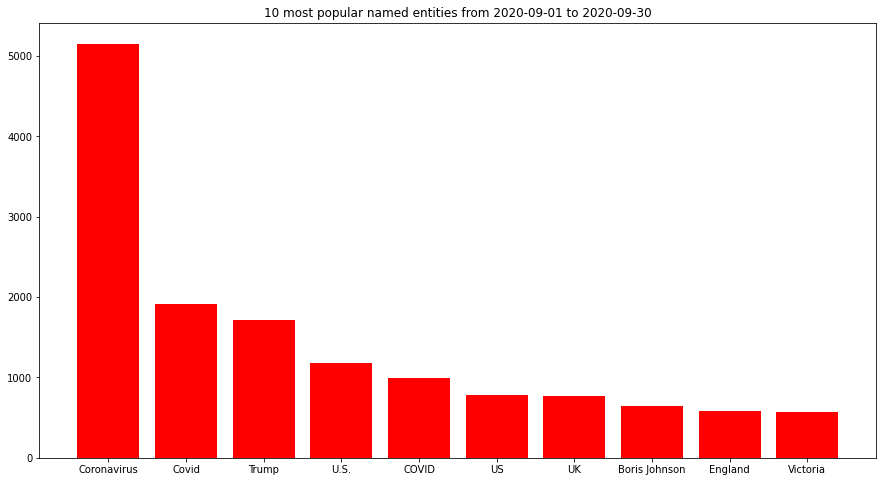

Finished processing articles:
Positive: 22387
Negative: 68384
DateFrom: 2020-10-01
DateTo: 2020-10-31
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.c

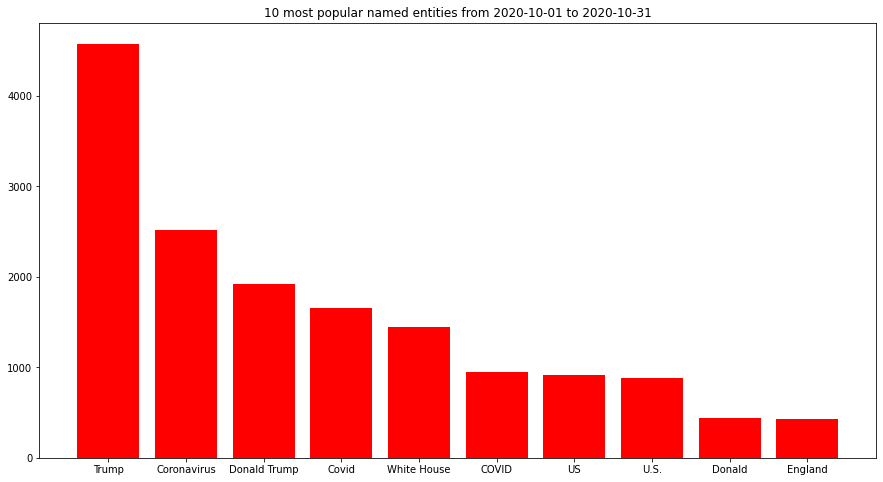

Finished processing articles:
Positive: 59
Negative: 451
DateFrom: 2020-11-01
DateTo: 2020-11-30
Domains: ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.com', 

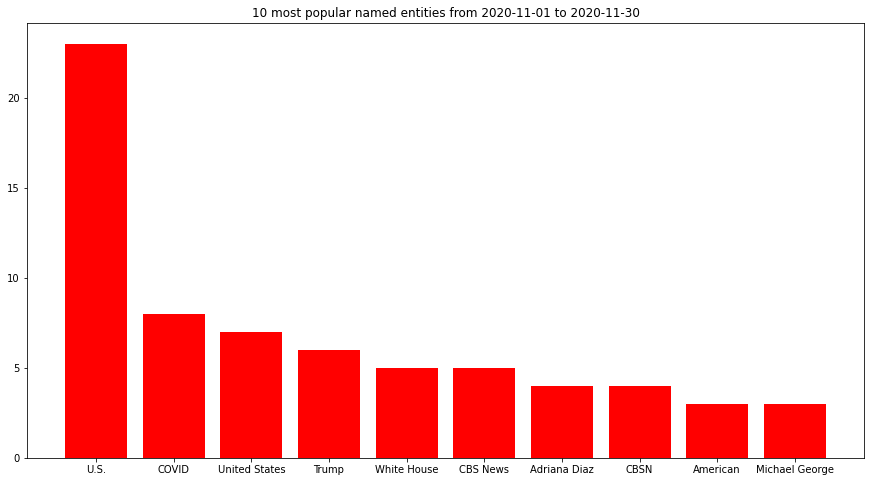

No articles found for year: 2020, month: 12, for domains ['scotsman.com', 'independent.ie', '9news.com.au', 'morningstaronline.co.uk', 'bbc.com', 'independent.co.uk', 'dailystar.co.uk', 'cbc.ca', 'theatlantic.com', 'afr.com', 'reuters.com', 'newshub.co.nz', 'wsj.com', 'rt.com', 'chicagotribune.com', 'montrealgazette.com', 'nypost.com', 'stuff.co.nz', 'npr.org', 'businessinsider.com', 'latimes.com', 'ctvnews.ca', 'cnbc.com', 'thewest.com.au', 'macleans.ca', 'inquirer.com', 'theglobeandmail.com', 'aljazeera.com', 'thejournal.ie', 'thestar.com', 'theage.com.au', 'washingtonpost.com', 'nytimes.com', 'channel4.com', 'thesun.co.uk', 'nzherald.co.nz', 'usatoday.com', 'news.sky.com', 'upi.com', 'foxnews.com', 'huffpost.com', 'edition.cnn.com', 'walesonline.co.uk', 'news.com.au', 'express.co.uk', 'irishmirror.ie', 'time.com', 'dw.com', 'thetimes.co.uk', 'breitbart.com', 'apnews.com', 'irishtimes.com', 'westernjournal.com', 'washingtontimes.com', 'theguardian.com', 'csmonitor.com', 'metro.co.uk'

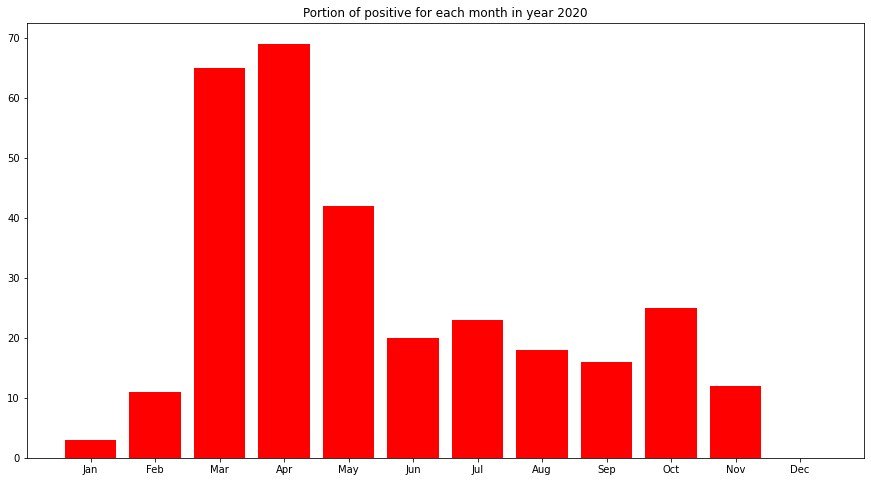

Finished processing articles:
Positive: 541441
Negative: 1266716
DateFrom: 20200101
DateTo: 20201231
Domains: All
Accuracy: 90.39 %
Portion of positive: 29.94 % 


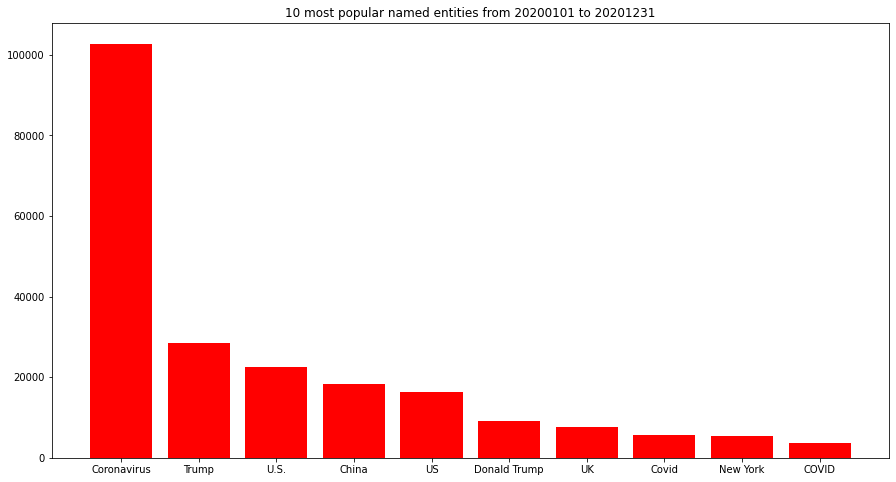

Finished processing articles:
Positive: 5371
Negative: 12045
DateFrom: 2020-01-01
DateTo: 2020-12-31
Domains: ['bbc.com']
Accuracy: 92.09 %
Portion of positive: 30.84 % 


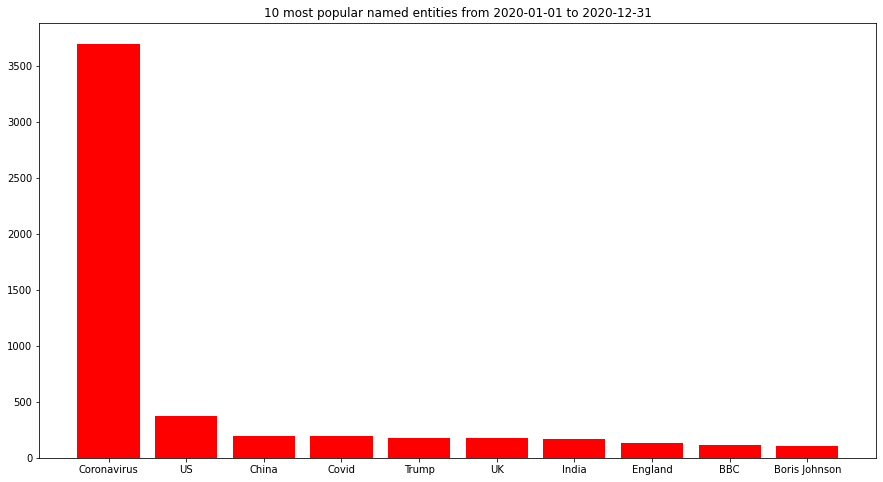

In [39]:
# The pipelines are used from this point

def add_to_dictionary(prev, newEntities):
    for i in newEntities:
        try:
            prev[i[0]] += i[1]
        except:
            prev[i[0]] = i[1]            
    return prev

def standardize_and_classify(articles):
    return classify_and_analyze(articles)

def process_articles(domains, dateFrom="", dateTo=""):
    articles, dateFrom, dateTo = get_articles(domains, dateFrom, dateTo)

    if(articles is None or len(articles) == 0):
        print(f"No articles found from {dateFrom} to {dateTo}, for domains {domains}")
    else:
        accuracy, positive, negative, namedProperties = standardize_and_classify(articles)

        # Display results from analyzation
        display_results(accuracy,
                    positive,
                    negative,
                    namedProperties,
                    domains,
                    dateFrom,
                    dateTo)

def process_articles_by_month(domains, year, month):
    articles, dateFrom, dateTo = get_articles_by_month(domains, year, month)
    if(articles is None or len(articles) == 0):
        print(f"No articles found for year: {year}, month: {month}, for domains {domains}")
        return 0, 0, 0, 0
    else:
        accuracy, positiveNum, negativeNum, namedProperties = standardize_and_classify(articles)

        # Display results from analyzation
        display_results(accuracy,
                    positiveNum,
                    negativeNum,
                    namedProperties,
                    domains,
                    dateFrom,
                    dateTo)
        
        return accuracy, positiveNum, negativeNum, namedProperties

# Process all articles for each month for certain year
def each_month(year):
    months = ["Jan","Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    outcome = []
    allPositiveNum = []
    allNegativeNum = []
    allAccuracy = []
    allNamedProperties = {}
    monthsCounter = 0
    for a in list(range(1, 13)):
        accuracy, positiveNum, negativeNum, namedProperties = process_articles_by_month(get_domains(), year, str(a))
        # Create an array that is used for displaying statistics for each month
        if(positiveNum != 0):
            monthsCounter += 1
            o = float(positiveNum)/(float(negativeNum)+float(positiveNum)) * 100
            outcome.append(round(o))
            allAccuracy.append(accuracy)
            allPositiveNum.append(positiveNum)
            allNegativeNum.append(negativeNum)
            allNamedProperties = add_to_dictionary(allNamedProperties, namedProperties)
        else:
            outcome.append(0)
            allAccuracy.append(accuracy)
            allPositiveNum.append(positiveNum)
            allNegativeNum.append(negativeNum)

    display_graph(f"Portion of positive for each month in year {year}", months, outcome)

    totalAccuracy = sum(allAccuracy) / monthsCounter

    allProps = filter_named_properties(allNamedProperties)

    display_results(totalAccuracy, sum(allPositiveNum),sum(allNegativeNum), allProps, "All", "20200101", "20201231")

#text_mine_articles(get_domains(), "20200101", "20201231")

# Process all articles for each month in 2020
each_month("2020")

# Process all artiles in an outlet in 2020
process_articles(["bbc.com"], "20200101", "20201231")